# Transformer

Implementation of the original paper "Attention is All You Need" https://arxiv.org/pdf/1706.03762

We will consider the task of translating Catalan to English.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

#### Input Embedding
Consider a vocabulary of `vocab_size` words. Each of them will have assign an integer. So the first thing we need is to encode a sentence by asigning these integers. This is what is called **tokenize**.  Then to each of this numbers we will assing a (learnable) vector of size a certain size, in the paper it is called $d_{\rm model}$.

In PyTorch we can use an `nn.Embedding` class to get this. It's simply a matrix of size `vocab_size` x `d_model`, and it simply selects the row that corresponds to the integer of the word (the total of words is `vocab_size`) and outputs the vector of size `d_model`. So for a sentence of size `context_size`, the output of the embedding is a tensor of size `context_size`x`d_model`.

In the paper they multiply the embedding output by $\sqrt{d_{\rm model}}$

In [3]:
# ------------------------------
# 
# Input Embedding
#
# ------------------------------

class InputEmbedding(nn.Module):
    def __init__(self, d_model : int, vocab_size : int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model) # multiplied by sqrt(d_model) in the paper

# Test
seq_len = 10 # The lenght of the input sequence
input_embedding = InputEmbedding(d_model=768, vocab_size=10)
x = torch.randint(0, seq_len, (5, 10)) # (N, context_size)
out = input_embedding(x)
print(out.shape)

torch.Size([5, 10, 768])


##### Positional Encoding

A Transformer has no knowledge about positions of the input sequence. We define a context length, that will be the maximum input for the model

torch.Size([1, 10, 128])


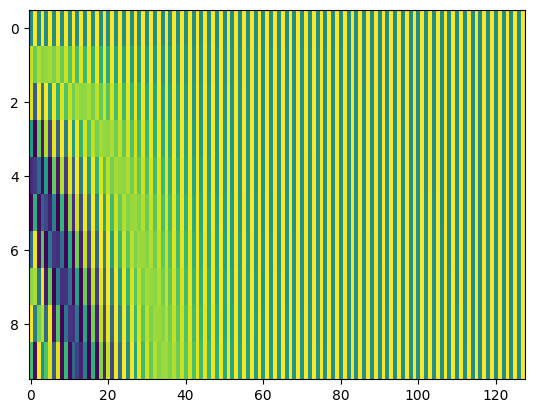

In [4]:
# ------------------------------
# 
# Positional Encoding
#
# ------------------------------

def sinusoidal_encoding(context_length, d_model):
    pe = torch.zeros(context_length, d_model)
    position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1) # the unsqueeze converts it to a (context_length, 1) tensor
    div_term = torch.exp( torch.arange(0, d_model, 2, dtype=torch.float) * (- np.log(10000.0)) / d_model) # (d_model/2)
    # position * div_term = (context_lenght, emb_dim/2)

    pe[:, ::2] = torch.sin(position * div_term) # sin for even positions
    pe[:, 1::2] = torch.cos(position * div_term) # cos for odd positions

    pe = pe.unsqueeze(0) # (1, context_length, d_model)
    return pe  


class PositionalEncoding(nn.Module):
    def __init__(self, d_model : int, context_length : int, dropout : float):
       super().__init__() 
       self.d_model = d_model
       self.context_length = context_length
       self.dropout = nn.Dropout(dropout)

       self.register_buffer('positional_encoding', sinusoidal_encoding(self.context_length, self.d_model)) # (1, context_length, d_model ))


    def forward(self, x):
       x = x + (self.positional_encoding[:, :x.shape[1], :]).requires_grad_(False) # only the text we have
       return self.dropout(x) # (batch, seq_len, d_model)


# Test

sin_enc = sinusoidal_encoding(context_length=10, d_model=128)
print(sin_enc.shape)
plt.imshow(sin_enc[0].numpy(), aspect='auto')


##### Layer Norm
From the paper https://arxiv.org/pdf/1607.06450

If we have a batch of size N, then for item in the batch, let's say sentences of seq_len size, then we compute the mean and the std of each one and normalize the element as

$$ x_i' = \gamma \dfrac{x_i - \mu_i}{\sqrt{\sigma_j^2 + \epsilon}} + \beta$$




In [5]:
# ------------------------------
# 
# Layer Norm
#
# ------------------------------

# TODO: check the mean(dim=-1). The sequence dimension is the dim = 1, no?

class LayerNorm(nn.Module):
    # is basically a batch norm (less complicated) across sequence dimension
    def __init__(self, epsilon : float = 1e-6):
        super().__init__()
        self.epsilon = epsilon # For numerical stability
        self.gamma = nn.Parameter(torch.ones(1)) # Learnable parameter (multiplicative parameter)
        self.beta = nn.Parameter(torch.zeros(1)) # Learnable parameter (bias)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdims=True)  # (batch, seq_len, 1)
        std = x.std(dim=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

##### Feed Forward Block

In additino to the attention layers, tey add fully connected feed-forward network applied to each position separately and identically. This consists of two linear transformations with a ReLU in between (Eq. 2 of the paper)
$$ \rm{FFN}(x) = max(0, x W_1 + b_1) W_2 + b_2 $$
THe input and output has dimension $d_{\rm model}$ and the inner-layer $d_{ff}$.

In [6]:
# ------------------------------
# 
# Feed Forward
#
# ------------------------------


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout : float):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = nn.Dropout(dropout)

        self.ff1 = nn.Linear(d_model, d_ff)
        self.ff2 = nn.Linear(d_ff, d_model)

    
    def forward(self, x):
        x = F.relu(self.ff1(x)) # (batch, seq_len, d_model) -> (batch, seq_len, d_ff)
        x = self.dropout(x) 
        x = self.ff2(x) # (batch, seq_len, d_ff) -> (batch, seq_len, d_ff)
        return x

##### Multi-Head Attention

- Section 3.2 of the paper.
- *TODO:* Check the formulas.
- Here we use the same dimension $d_k$ for the keys, queries and **also** for the values, although they could be different

In [26]:
# ------------------------------
# 
# Muli-Head Attention
#
# ------------------------------

# 1. The multihead attention dividies the embedding dimension into multiple smaller attentions. 
# 2. The number of heads must divide the input dimension (the sequence one)

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model : int, nheads : int, dropout : float):
        super().__init__()
        assert d_model % nheads == 0, "nheads must divide d_model" # check that d_model can be divided by the num of heads
        self.emb_dim = d_model
        self.nheads = nheads
        self.dk = d_model // nheads

        self.dropout = nn.Dropout(dropout)
        self.Wq = nn.Linear(d_model, d_model, bias=False) # Wq
        self.Wk = nn.Linear(d_model, d_model, bias=False) # Wk
        self.Wv = nn.Linear(d_model, d_model, bias=False) # Wv
        self.Wo = nn.Linear(d_model, d_model, bias=False) # Wo

   
    @staticmethod
    def attention(query, key, values, mask, dropout: nn.Dropout):
        dk = query.shape[-1]

        # Mulitply queries and keys
        attention_scores = query @ key.transpose(-1, -2) / np.sqrt(dk) # (batch, nhead, seq_len, dk) @  (batch, nhead, dk, seq_len) -> (batch, nhead, seq_len, seq_len)
        
        # If mask is defined, then apply it. Basically, all the indices that in the mask are zero, then replace it with -inf
        if mask is not None: attention_scores.masked_fill(mask == 0, -torch.inf)

        # Apply softmax (the -inf will be 0)
        attention_scores = attention_scores.softmax(dim=1) # sofmax each row (B, nhead, seq, seq)
        
        # Apply dropout
        if dropout is not None: attention_scores = dropout(attention_scores)

        # Finally multiply by the values
        x = attention_scores @ values # (batch, nhead, seq_len, seq_len) @ (batch, nhead, seq_len, dk) -> (batch, nhead, seq_len, dk)

        return x, attention_scores # We also return te attention scores for later visualization

    def forward(self, q, k, v, mask):
        
        qi = self.Wq(q) # (batch, seq_len, d_model) @ (batch, d_model, d_model) -> (batch, seq_len, d_model)
        ki = self.Wk(k) 
        vi = self.Wv(v) 

        # Split across the embedding dimension and rearange.
        # (batch, seq_len, d_model) -> (batch, seq_len, nhead, dk = d_model/nheads) ->  (batch, nhead, seq_len, dk)
        qi = qi.view(qi.shape[0],  qi.shape[1], self.nheads, self.dk).transpose(1,2) # (batch, nhead, seq_len, dk = d_model/nheads)
        ki = ki.view(ki.shape[0],  ki.shape[1], self.nheads, self.dk).transpose(1,2)
        vi = vi.view(vi.shape[0],  vi.shape[1], self.nheads, self.dk).transpose(1,2)

        # Calculate attention 
        x, self.attention_scores = self.attention(qi, ki, vi, mask, self.dropout)  # (batch, nhead, seq_len, dk) 
        
        # Concat the heads
        # (batch, nhead, seq_len, dk) -> (batch, seq_len, nheads, dk) -> (batch, seq_len, d_model)
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.nheads * self.dk) # (batch, seq_len, d_model). 

        # Apply a last linear layer
        x = self.Wo(x) # (batch, seq_len, d_model) @ (d_model, d_model) -> (batch, seq_len, d_model)

        return x 

##### Residual Connection

We need a skip conection

In [8]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout : float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm()

    def forward(self, x, sublayer):
        # Slightly different from the original paper, we first apply the norm, then the sublayer
        return x + self.dropout(sublayer(self.norm(x)))

##### Encoder Layer
An encoder layer will have a Mult-Head Attention block and a Feed-Forward Block

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, nheads: int, dropout: float):
        super().__init__()
        self.self_attention = MultiHeadAttentionBlock(d_model=d_model, nheads=nheads, dropout=dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, source_mask):
        # The first residual connection
        x = self.residual_connections[0](x, lambda x : self.self_attention(x, x, x, source_mask))
        # The second residual conection 
        x = self.residual_connections[1](x, self.feed_forward)
        return x

##### Encoder

The encoder will consist on $N$ encoder layers

In [10]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNorm()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

##### Decoder Layer

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, nheads: int, dropout: float):
        super().__init__()
        self.self_attention = MultiHeadAttentionBlock(d_model, nheads, dropout)
        self.cross_attention = MultiHeadAttentionBlock(d_model, nheads, dropout) 
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, source_mask, target_mask):
        # First residual connection (self-attention for the decoder)
        x = self.residual_connections[0](x, lambda x: self.self_attention(x, x, x, target_mask)) # mask for the decoder
        # Second residual connection (cross-attention, the queries come from the decoder, keys and values come from the encoder)
        x = self.residual_connections[1](x, lambda x: self.cross_attention(x, encoder_output, encoder_output, source_mask))
        # Thrid residual connection (feed-forward)
        x = self.residual_connections[2](x, self.feed_forward)

        return x



##### Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNorm()

    def forward(self, x, encoder_output, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, source_mask, target_mask)
        return self.norm(x)

##### Linear Layer 

1. This last layer will convert the embedding layer to the sequence.
2. The ouput will be the log probabilities (logits) for each input what is the corresponding out word

In [13]:
class LinearLayer(nn.Module): # convert from the embedding to the vocabulary
    def __init__(self, d_model : int, out_vocab_size : int):
        super().__init__()
        self.d_model = d_model
        self.out_vocab_size = out_vocab_size

        self.linear = nn.Linear(d_model, out_vocab_size)

    def forward(self, x):
        x = self.linear(x) # (batch, seq_len, d_model) @ (d_model, out_vocab_size) -> (batch, seq_len, out_vocab_size)j
        return x # return the logits

        # x = F.log_softmax(x, dim=-1) # we return the log softmax, then exponentiate to get probablities, more stable??
        # return x  

##### Transformer
Combine everything

In [14]:
class Transformer(nn.Module):
    def __init__(self, 
                 source_context_length : int, 
                 target_context_length : int, 
                 d_model : int, 
                 nlayers : int, 
                 d_ff : int, 
                 nheads : int,
                 source_vocab_size : int,
                 target_vocab_size : int,
                 dropout : float):
        super().__init__()
        
        # Hyperparams
        self.d_model = d_model
        self.source_context_length = source_context_length
        self.target_context_length = target_context_length
        self.nlayers = nlayers
        self.d_ff = d_ff
        self.nheads = nheads
        self.dropout = dropout

        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size

        # Encoder
        self.encoder = Encoder(nn.ModuleList([EncoderLayer(d_model, d_ff, nheads, dropout) for _ in range(nlayers)]))
        self.source_input_embedding = InputEmbedding(d_model, source_vocab_size)
        self.source_positional_encoding = PositionalEncoding(d_model, source_context_length, dropout)

        # Decoder
        self.decoder = Decoder(nn.ModuleList([DecoderLayer(d_model, d_ff, nheads, dropout) for _ in range(nlayers)]))
        self.target_input_embedding = InputEmbedding(d_model, target_vocab_size)
        self.target_positional_encoding = PositionalEncoding(d_model, target_context_length, dropout)

        # Last linear layer
        self.linear = LinearLayer(d_model, target_vocab_size)

        # Init the parameters after building all the blocks
        self._init_parameters()

    def encode(self, source, source_mask):
        source = self.source_input_embedding(source)
        source = self.source_positional_encoding(source)
        return self.encoder(source, source_mask)

    def decode(self, target, encoder_output, source_mask, target_mask):
        target = self.target_input_embedding(target)
        target = self.target_positional_encoding(target)
        return self.decoder(target, encoder_output, source_mask, target_mask)
    
    def project(self, x):
        return self.linear(x)
    
    # Initiliazion of the parameters, as in the paper. I think PyTorch does it automatically, because all are linear layers. 
    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)


    def forward(self, encoder_input, decoder_input, encoder_mask, decoder_mask):
        encoder_ouput = self.encode(encoder_input, encoder_mask)  
        decoder_ouput = self.decode(decoder_input, encoder_ouput, encoder_mask, decoder_mask) 

        logits = self.project(decoder_ouput) 
        return logits
        


In [15]:
# Configuration of the paper
paper_config = {
    'd_model': 512,
    'nlayers' : 6,
    'nheads' : 8,
    'dropout' : 0.1,
    'd_ff' : 2048,
    'seq_len': 300, # more than enough
    'source_lang': 'ca',
    'target_lang': 'en',
}


### The training

**Encoder**
- The input of the encoder is the sentence in catalan. In the form of 
        
        SOS (sentence in Catalan) EOS 
with the two special tokens Start Of Sentence and End Of Sentence. 
- The input will have a dimension of (batch, seq_len, d_model), before we had (seq_len, source_vocab_size) but with the embedding we convert it to (seq_len, d_model). 
- The output will have the same dimensions. For each word, the ouput vector captures not only the meaning (embedding) or the position, but also the interaction with other words 
- To have the same seq_len for all sentences in a batch, we pad them with a special token PAD.

**Decoder** 
- The input of the decoder will be the sentence in the form 

        SOS (sentence in English)
without the EOS token. It will have dimensions of (batch, seq_len, d_model).
- We prepend the SOS token at the beginning, that's why in the paper says that the decoder input is shifted to the right
- To have the same seq_len for all sentences in a batch, we pad them with a special token PAD.
- The decoder ouput will have dimensions (batch, seq_len, d_model)
- The output of the decoder wil be fed to the last linear layer to transform it to (seq_len, target_vocab_size). 
- Apply softmax to get the probabilties for each output token

**The target**
- The target will of the form: 
        
        (sentence in English) EOS 
without the SOS token. We will compute a Cross Entropy Loss between the probabilites and the this target.

**Why the special tokens**

Let us consider we want to translate the sentence: 
        
        SOS La casa vermella es gran EOS

During the training, the input of the decoder will be

        SOS The red house is big

The target will be:

        The red house is big EOS

Now, the idea is that 
        
- when we have a *SOS* -> we want to ouput a *The*
- *The* -> *red*
- *red* -> *house*
- *house* -> *is*
- *is* -> *big*
- *big* -> *EOS*

This is just one time step. And we have done it everything in **one** time step. That is the power of the Transformer. That's the advantaged over the RNN, that to process N tokens we need N time steps.

### Inference

- The input of the encoder is the same, with (seq_len, d_model)

- The input of the decoder will be just the SOS token (and the padding to have the same lenght)
- The ouput of the decoder will be the logits, that after the softmax will be probabiliteis assign to each token of the vocabulary. We take the token with the maximum probability, and this will be the next predicted token.

This is one time step. The next, is to use the same encoder output (there is no need to recompute it again). Use the output of the decoder as the input of the decoder. Do the same until we see the EOS in the decoder output.

**Notes**
- What we have used for the inference is called *greedy strategy*. At each step, we select the word with the maximum softmax value.
- There is another strategy, called *beam search*. At each step, we select the top B words and evaluate all the possible next words for each of them and at each step, keeping the top B most probable sequences. This usually performs better.



### The dataset

We will use the Opus Books dataset, from catalan to english

##### The tokenizer

- We need to set a tokenizer. There are **lots** of several ways to tokenize a sentence. OpenAI GPT models for instance use tokenizer that encode sylables or more words.
- We will use a tokenizer that encodes each word separatly.
- We will use the Hugging Face library ``tokenizer``. At some point we can be our own.

In [16]:
# Download it from https://huggingface.co/datasets/Helsinki-NLP/opus_books/tree/main/ca-en
# !wget https://huggingface.co/datasets/Helsinki-NLP/opus_books/blob/main/ca-en/train-00000-of-00001.parquet

import pandas as pd
dataset = pd.read_parquet('./data/opus_books_ca_en.parquet', engine='fastparquet').drop(index=0).reset_index(drop=True)
dataset

,id,translation.ca,translation.en
0,1,Les Aventures De Tom Sawyer,The Adventures of Tom Sawyer
1,2,Mark Twain,Mark Twain
2,3,PREFACI.,PREFACE
3,4,La major part de les aventures consignades en ...,Most of the adventures recorded in this book r...
4,5,Huck Finn és tret de la vida real; Tom Sawyer ...,"Huck Finn is drawn from life; Tom Sawyer also,..."
...,...,...,...
4599,4600,Així acaba aquesta cronica.,SO endeth this chronicle.
4600,4601,Com que és estrictament la historia d'un minyó...,"It being strictly a history of a _boy_, it mus..."
4601,4602,"Quan hom escriu una novel·la sobre gent gran, ...","When one writes a novel about grown people, he..."
4602,4603,La major part dels personatges que surten en a...,Most of the characters that perform in this bo...


In [17]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path
def get_all_sentences(dataset, lang):
    for item in dataset[f'translation.{lang}']:
        yield item

# Check https://huggingface.co/docs/tokenizers/pipeline
def get_tokenizer(tokenizer_path, dataset, lang):
    if not Path.exists(Path(tokenizer_path)):
        print(f"The tokenizer with path {tokenizer_path} does not exists, creating a new one")
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(dataset, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        print(f"Getting tokenizer from {tokenizer_path}")
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

# Get the tokenizers
tokenizer_source = get_tokenizer("./tokenizer_ca.json", dataset, 'ca')
tokenizer_target = get_tokenizer("./tokenizer_en.json", dataset, 'en')

# Test
tokens_source = tokenizer_source.encode("Hola que tal").ids
print(f"encoded sentence: {tokens_source}")
print(f"decoded sequence: {tokenizer_source.decode(tokens_source)}")

Getting tokenizer from ./tokenizer_ca.json
Getting tokenizer from ./tokenizer_en.json
encoded sentence: [1458, 11, 1078]
decoded sequence: Hola que tal


In [18]:
# Create a dataset for retrieving data from

def causal_mask(size):
    # This create a matrix of size x size with the lower diagonal filled with ones (including the diagonal). 
    # This makes that tokens can only interact with past tokens and themselfs
    mask = torch.tril(torch.ones(1, size, size)).type(torch.int)  == 1 
    return mask 

class BilingualDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, tokenizer_source, tokenizer_target, source_lang, target_lang, context_length):
        super().__init__()
        self.dataset = dataset
        self.tokenizer_source = tokenizer_source
        self.tokenizer_target = tokenizer_target
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.context_length = context_length

        special_tokens = ['[SOS]', '[EOS]', '[PAD]']
        self.special_tokens = { token:torch.tensor([tokenizer_source.token_to_id(token)], dtype = torch.int64) for token in special_tokens} 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        element = self.dataset.loc[index]
        source_text = element[f'translation.{self.source_lang}']          
        target_text = element[f'translation.{self.target_lang}']          

        source_tokens = tokenizer_source.encode(source_text).ids
        target_tokens = tokenizer_target.encode(target_text).ids

        # In a batch, the sentences will have different lenghts, that's why we need to pad the, using the [PAD] token
        encoder_input_padding = self.context_length - len(source_tokens) - 2 # take into account the [SOS] and [EOS] ones
        decoder_input_padding = self.context_length - len(target_tokens) - 1 # take into account only the [EOS] token, since the input of the decoder is already the [SOS] token

        if encoder_input_padding < 0 or decoder_input_padding < 0 :
            raise ValueError("Sentence is too long") 
        
        encoder_input = torch.cat( [
                self.special_tokens['[SOS]'],
                torch.tensor(source_tokens, dtype=torch.int64),
                self.special_tokens['[EOS]'],
                torch.tensor([self.special_tokens['[PAD]']]*encoder_input_padding, dtype=torch.int64)
            ])
        
        # Adding SOS to the decoder input
        decoder_input = torch.cat([
                self.special_tokens['[SOS]'],
                torch.tensor(target_tokens, dtype=torch.int64),
                torch.tensor([self.special_tokens['[PAD]']]*decoder_input_padding, dtype=torch.int64)
            ])

        # Adding EOS to labels 
        labels = torch.cat([
                torch.tensor(target_tokens, dtype=torch.int64),
                self.special_tokens['[EOS]'],
                torch.tensor([self.special_tokens['[PAD]']]*decoder_input_padding, dtype=torch.int64)
            ])

        assert encoder_input.shape[0] == self.context_length
        assert decoder_input.shape[0] == self.context_length
        assert labels.shape[0] == self.context_length

        return { 
            'encoder_input':encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.special_tokens['[PAD]']).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.special_tokens['[PAD]']).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.shape[0]),
            'labels': labels,
            'source_text': source_text,
            'target_text': target_text
            }


In [19]:
# Test
torch.manual_seed(1234)
random_indices = torch.randperm(len(dataset))
train_ratio = 0.9
val_ratio = 1 - train_ratio

train_set = dataset.iloc[random_indices[:int(train_ratio*len(dataset))]].reset_index(drop=True)
val_set = dataset.iloc[random_indices[int(train_ratio*len(dataset)):]].reset_index(drop=True)

print(f"{len(train_set)=}, {len(val_set)=}")

context_length = 100

train_dataset =  BilingualDataset(train_set, tokenizer_source=tokenizer_source, tokenizer_target=tokenizer_target, source_lang='ca', target_lang='en', context_length=context_length)

val_dataset =  BilingualDataset(train_set, tokenizer_source=tokenizer_source, tokenizer_target=tokenizer_target, source_lang='ca', target_lang='en', context_length=context_length)

len(train_set)=4143, len(val_set)=461


In [20]:
def get_dataset_splits(dataset, train_ratio, source_lang, target_lang, context_length, seed=None):

    # Get the tokenizers
    tokenizer_source = get_tokenizer(f"./tokenizer_{source_lang}.json", dataset, source_lang)
    tokenizer_target = get_tokenizer(f"./tokenizer_{target_lang}.json", dataset, target_lang)

    # Check the maximum source and target lengths
    max_len_source, max_len_target = 0, 0
    for i, row in dataset.iterrows():
        source_ids = tokenizer_source.encode(row[f"translation.{source_lang}"]).ids
        target_ids = tokenizer_target.encode(row[f"translation.{target_lang}"]).ids
        max_len_source = max(max_len_source, len(source_ids)) 
        max_len_target = max(max_len_target, len(target_ids)) 

    print(f"Maximum length of source sentence: {max_len_source}")
    print(f"Maximum length of target sentence: {max_len_target}")
    assert context_length >= max_len_source and context_length >= max_len_target

    if seed != None : torch.manual_seed(seed)
    random_indices = torch.randperm(len(dataset))
    print(random_indices)
    train_set = dataset.iloc[random_indices[:int(train_ratio*len(dataset))]].reset_index(drop=True)
    val_set = dataset.iloc[random_indices[int(train_ratio*len(dataset)):]].reset_index(drop=True)
    print(f"{len(train_set)=}, {len(val_set)=}")


    train_dataset =  BilingualDataset(train_set, tokenizer_source=tokenizer_source, tokenizer_target=tokenizer_target, source_lang=source_lang, target_lang=target_lang, context_length=context_length)

    val_dataset =  BilingualDataset(train_set, tokenizer_source=tokenizer_source, tokenizer_target=tokenizer_target, source_lang=source_lang, target_lang=target_lang, context_length=context_length)

    return train_dataset, val_dataset, tokenizer_source, tokenizer_target


In [21]:
train_dataset, val_dataset, tokenizer_source, tokenizer_target = get_dataset_splits(dataset, 0.9, 'ca', 'en', 250 ,1234)

Getting tokenizer from ./tokenizer_ca.json
Getting tokenizer from ./tokenizer_en.json
Maximum length of source sentence: 220
Maximum length of target sentence: 210
tensor([ 719,   92, 1802,  ..., 1116, 3374, 3614])
len(train_set)=4143, len(val_set)=461


In [22]:
tokenizer_target.get_vocab_size(), tokenizer_source.get_vocab_size()

(3927, 4592)

####  Training loop

In [41]:
# ------------------------
#
# Prepare the training
#
# -------------------------

from tqdm import tqdm
import time
import sys
import math
def CFG(text, color): return "\33[38;5;" + str(color) + "m" + text + "\33[0m"

# ---------------------------
#
#  The model parameters
#
# ---------------------------

# Configuration of the paper
model_config = {
    'd_model': 512,
    'nlayers' : 6,
    'nheads' : 8,
    'dropout' : 0.1,
    'd_ff' : 2048,
    'source_context_length': 300, # more than enough
    'target_context_length': 300, # more than enough
    'source_vocab_size': tokenizer_source.get_vocab_size(),
    'target_vocab_size': tokenizer_target.get_vocab_size()
}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Transformer(**model_config)
model.to(device)


# ---------------------------
#
#  Get data
#
# ---------------------------

batch_size = 8

# initialize the dataloaders after re-seed
torch.manual_seed(0)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

# For now we do it like that, not the ideal, because we are creating an iterator at each call
def get_data(split):
    iterator = iter(train_dataloader) if split == 'train' else iter(val_dataloader)
    batch = next(iterator)
    return batch


# ---------------------------
#
#  Loss function
#
# ---------------------------

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_source.token_to_id('[PAD]'), label_smoothing=0.1).to(device)


# ---------------------------
#
#  Compute model_metrics
#
# ---------------------------

def compute_model_metrics(batch):
    
    encoder_input = batch['encoder_input'].to(device) # (batch, context_length)
    decoder_input = batch['decoder_input'].to(device) # (batch, context_length)
    encoder_mask = batch['encoder_mask'].to(device) # (batch, 1, 1, context_length)
    decoder_mask = batch['decoder_mask'].to(device) # (batch, 1, context_length, context_length)
    labels = batch['labels'].to(device) # (batch, context_lenght)

    logits = model.forward(encoder_input, decoder_input, encoder_mask,decoder_mask) # (batch, context_length, target_vocab_size)

    # reshape the logits and the labels to feed into the loss function
    logits  = logits.view(-1, tokenizer_target.get_vocab_size()) # (batch * context, vocab_size)
    # labels = F.one_hot(labels.view(-1), num_classes=tokenizer_target.get_vocab_size())
    labels = labels.view(-1)

    loss = loss_fn(logits, labels)

    return {'loss': loss}


# ---------------------------
#
#  Learning rate schedule
#
# ---------------------------

learning_rate = 1e-4

def get_lr(it):
    return learning_rate

# ---------------------------
#
#  Optimizer
#
# ---------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-9)

# ---------------------------
#
#  Configure how to evaluate the metrics
#
# ---------------------------

metrics_to_eval = ['loss'] # they have to be returned from the method forward_batch() of the model
eval_iters = 5

@torch.no_grad()
def estimate_metrics():
    out_dicts = {s: {} for s in metrics_to_eval}
    model.eval()  # set the model to eval mode
    for split in ["train", "val"]:
        max_iters = eval_iters
        local_dicts = {s: torch.zeros(max_iters) for s in metrics_to_eval}
        for k in tqdm(range(max_iters), file=sys.stdout, desc=f"{CFG('[train]',11)}" if split == "train" else f"{CFG('[ val ]',11)}"):
            batch = get_data(split)
            fb = compute_model_metrics(batch)
            for metric in metrics_to_eval:
                local_dicts[metric][k] = fb[metric].item()

        for metric in metrics_to_eval:
            out_dicts[metric][split] = local_dicts[metric].mean()

    model.train()  # set the model back to train mode
    return out_dicts

best_val_loss = 1e9
info = { 'iter_num': [], 'lr': [],  **{ m : {'train': [], 'val': []} for m in metrics_to_eval}}


# ---------------------------
#
#  Visualize during training
#
# ---------------------------

def greedy_decode(model, encoder_input, encoder_mask, tokenizer_source, max_length ):
    sos_idx = tokenizer_source.token_to_id('[SOS]')
    eos_idx = tokenizer_source.token_to_id('[EOS]')

    # precompute the encoder output and reuse it
    encoder_output = model.encode(encoder_input, encoder_mask)

    # initizalize the decoder input with the sos token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(encoder_input).to(device)

    while True:
        if decoder_input.shape[1] == max_length:
            break
        decoder_mask = causal_mask(decoder_input.shape[1]).type_as(encoder_mask).to(device)

        # output of the decoder
        decoder_output = model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)

        # get the next token. Project the last token
        probabilities = torch.softmax(model.project(decoder_output[:,-1]) , dim=-1)
        _ , next_word = torch.max(probabilities, dim=1) 
        decoder_input = torch.cat([decoder_input, torch.empty(1,1).type_as(encoder_input).fill_(next_word.item())])

        if next_word == eos_idx:
            break
    
    return decoder_input.squeeze(0)


@torch.no_grad()
def inference_visualization_during_training(model, max_length, print_msg):
    model.eval()

    # source_texts = []
    # expected_texts = []
    # predicted_texts = []

    # size of the control window 
    console_width = 80

    batch = get_data('val')

    encoder_input = batch['encoder_input'].to(device) # (batch, context_length)
    encoder_mask = batch['encoder_mask'].to(device) # (batch, 1, 1, context_length)
    source_text = batch['source_text'][0]
    target_text = batch['target_text'][0]
    
    print(encoder_input.shape, encoder_mask.shape) 
    out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_source, max_length)
    print(out) 
    predicted_text = tokenizer_target.decode(out.detach().cpu().numpy())
    
    # source_texts.append(source_text)
    # expected_texts.append(target_text)
    # predicted_texts.append(predicted_text)

    print_msg('-'*console_width)
    print_msg(f"[source]: {source_text}")
    print_msg(f"[expected]: {target_text}")
    print_msg(f"[prediced]: {predicted_text}")

    model.train()


In [42]:
inference_visualization_during_training(model, max_length=context_length, print_msg=print)

torch.Size([1, 250]) torch.Size([1, 1, 1, 250])


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [36]:
# ---------------------------
#
#  Train loop
#
# ---------------------------
from datetime import datetime
num_iterations = 5000
gradient_accumulation_steps = 5
log_interval = 10
eval_interval = 10
checkpoint_name = "./checkpoints/checkpoint_" + datetime.now().strftime("%y%m%d%H%M%S") + ".pt"
max_iters = 600000


batch = get_data('train') # the first batch
model.to(device)
iter_num = info['iter_num'][-1] if len(info['iter_num']) != 0 else 0
for it in range(num_iterations):
    lr = get_lr(it)
    t0 = time.time()

    # evaluate the metrics
    if iter_num % eval_interval == 0: 
        # estimate metrics at the eval_interval and convert it to numbers if tensors. Print it. Store the info
        out_estimates = {k: { s:(v[s].item() if isinstance(v[s], torch.Tensor) else v[s] ) for s in ['train', 'val'] }  for k,v in estimate_metrics().items()}
        print( CFG(f"[step {iter_num}]", 1) + ": " + "".join( [ CFG(f"train {metric}: {out_estimates[metric]['train']:.4f} ", k + 2) + CFG(f"val {metric}: {out_estimates[metric]['val']:.4f} ", k + 2) for k, metric in enumerate(metrics_to_eval) ]))
        info['lr'].append(lr); info['iter_num'].append(iter_num); [info[m]['train'].append(out_estimates[m]['train']) for m in metrics_to_eval]; [info[m]['val'].append(out_estimates[m]['val']) for m in metrics_to_eval]

    # do the backprop, we do it for gradient_accumulation_steps, to simulate larger batches. If gradient_accumulation_steps = 1, then it is like the usual
    model.train()
    optimizer.zero_grad(set_to_none=True) # flush the gradients, save memory
    
    for micro_step in range(gradient_accumulation_steps):
        fb = compute_model_metrics(batch) 
        loss = fb["loss"] / gradient_accumulation_steps
        batch = get_data("train")  # get the following batch
        loss.backward()  # do the backprop, accumulate all the gradients

    # update the parameters
    for g in optimizer.param_groups:
        g['lr'] = lr

    optimizer.step()

    # log loss of batch
    t1 = time.time(); dt = t1 - t0; t0 = t1
    if iter_num % log_interval == 0: print(f"Iteration {iter_num}: Train Loss of the batch {loss.item() *  gradient_accumulation_steps:.4f}, Time {dt*1000:.2f}ms")

    if out_estimates['loss']['val'] < best_val_loss:
        best_val_loss = out_estimates['loss']['val']
        checkpoint = {
            "model": model.state_dict(),  # stores the weights of the model
            "optimizer": optimizer.state_dict(),  # stores the optimizer state
            "iter_num": iter_num,
            "best_val_loss": best_val_loss,
            "info": info,
        }
        torch.save(checkpoint, checkpoint_name)
        print("Saving checkpoint")

    # visualize some sentences during training
    if iter_num % eval_interval:
        inference_visualization_during_training(model, max_length=context_length, print_msg = print)


    # update the iterations and if terminate if necessary
    iter_num += 1
    if iter_num > max_iters: break


[ val ]: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]
[step 0]: train loss: 8.3540 val loss: 8.3331 
Iteration 0: Train Loss of the batch 8.3783, Time 10657.90ms
Saving checkpoint


TypeError: argument 'ids': only integer scalar arrays can be converted to a scalar index

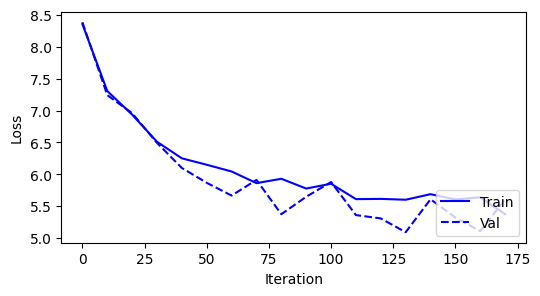

In [31]:
# ---------------------------
#
#  Plot the metrics
#
# ---------------------------

plt.figure(figsize=(6,3))
plt.plot(info['iter_num'], info['loss']['train'], label="Train", color='blue')
plt.plot(info['iter_num'], info['loss']['val'], label="Val", color='blue', ls='dashed')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='lower right')